In [23]:
import cv2 
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
from skimage import color
import numpy as np
import numpy as pynum_float
from scipy import spatial
import mahotas 
import math
from scipy.spatial import distance

Image Shape: (400, 300, 3)
Red Channel (400, 300)


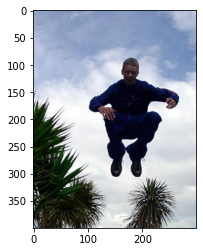

In [24]:
#Reading Image 

I = mpimg.imread('./MT19124_KomalKumari_A1/Q1/Man.jpg')
plt.imshow(I) 
print("Image Shape:",I.shape)

R=I[:,:,0]
G=I[:,:,1]
B=I[:,:,2]
print("Red Channel",R.shape)

In [25]:
#Creating bins per channel

bin_per_channel=pynum_float.arange(10.5,255,21) # 0-21,22-42,43-64,...234-255.
print("Bins:",bin_per_channel)


#Centroid for each bin or Total colour brought down from 256^3 to 1728
centroids={} # storing centroids of each bin
t=0
for i in range(0,12):
    for j in range(0,12):
        for k in range(0,12):
            t=t+1
            temp=[]
            temp.append(bin_per_channel[i])
            temp.append(bin_per_channel[j])
            temp.append(bin_per_channel[k])
#             temp=[bin_per_channel[i],bin_per_channel[j],bin_per_channel[k]]
            centroids[t]=temp
print("Example of Centroid:",centroids[11])
print("No of centroid:",len(centroids))

Bins: [ 10.5  31.5  52.5  73.5  94.5 115.5 136.5 157.5 178.5 199.5 220.5 241.5]
Example of Centroid: [10.5, 10.5, 220.5]
No of centroid: 1728


In [26]:
#Creating color histogram based on 1728 bins/colours
H={}
for i in range(0,len(I)):
    for j in range(0,len(I[0])):
        r=max((1,math.ceil(R[i][j]/22)))
        g=max((1,math.ceil(G[i][j]/22)))
        b=max((1,math.ceil(B[i][j]/22)))
        hi=144*(r-1)+12*(g-1)+b
        if(hi in H):
            H[hi]=H[hi]+1
        else:
            H[hi]=1
print(len(H))

197


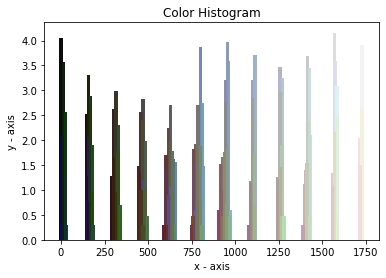

In [27]:
def plotting(X,Y,c):
    plt.bar(X, Y,color=c,width=20)
    plt.xlabel('x - axis') 
    plt.ylabel('y - axis') 
    plt.title('Color Histogram') 
    plt.show() 
    
#Plotting Histogram

c=list()
for key,values in H.items():
    temp=centroids[key]
    temp=[i/255 for i in temp]
    c.append(temp)
X=list(H.keys())
# Y=list(H.values())
Y=[math.log(y,10) for y in H.values()]
plotting(X,Y,c)

In [28]:
#Top 85 colours bins

H={k: v for k, v in sorted(H.items(), key=lambda item: item[1],reverse=True)}
H_85 = dict(list(H.items())[0: 85]) 
H_res=dict(list(H.items())[85: :])
print(H_85.values())

dict_values([14348, 11145, 9499, 8274, 7298, 6228, 5101, 4803, 4767, 3934, 3881, 3677, 2950, 2872, 2035, 1933, 1792, 1788, 1624, 1583, 1422, 1396, 1211, 985, 939, 839, 780, 699, 662, 596, 545, 544, 519, 505, 432, 419, 373, 369, 367, 332, 306, 252, 232, 231, 228, 207, 202, 184, 178, 176, 146, 145, 144, 140, 137, 133, 129, 121, 115, 114, 110, 108, 107, 97, 96, 95, 87, 85, 81, 79, 77, 74, 66, 65, 63, 62, 61, 59, 56, 51, 51, 47, 46, 45, 43])


In [29]:
#Allocating remaining colours to the closest bins

temp=dict() # to store all pixels to which rest 85 are to be compared
for key,value in H_85.items():
    lab_color = color.rgb2lab([[centroids[key]]]) #RGB to Lab space
    temp[tuple(lab_color[0][0])]=key #stores Lab values for a given RGB of H_85


vector=[list(i) for i in temp.keys()] # vector of all centroids of bins in 85 in Lab
mapping=dict()# which bins mapped to which bins
for key,value in H_res.items():
    pixel=color.rgb2lab([[centroids[key]]])[0][0]
    tree = spatial.KDTree(vector)
    res=vector[tree.query(pixel)[1]]
    H_85[temp[tuple(res)]]+=value
    mapping[key]=temp[tuple(res)]

(400, 300, 3)


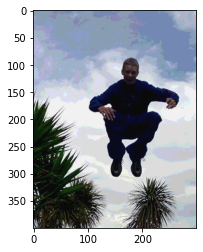

In [30]:
# Reading image from using just 85 Colours

temp_I=[]
for i in range(0,len(I)):
    for j in range(0,len(I[0])):
        r=max((1,math.ceil(R[i][j]/22)))
        g=max((1,math.ceil(G[i][j]/22)))
        b=max((1,math.ceil(B[i][j]/22)))
        hi=144*(r-1)+12*(g-1)+b
        if(hi in H_85):
            a=centroids[hi]
        else:
            a=centroids[mapping[hi]]
        temp=[i/255 for i in a]
        temp_I.append(temp)

temp_I=np.array((temp_I)).reshape(len(I),len(I[0]),3)
print(temp_I.shape)
plt.imshow(temp_I) 

In [31]:
# Saliency Calculation for each color 


#calcluating saliency Value
S={}
temp={}
for key,value in H_85.items():
    pixel_source=color.rgb2lab([[centroids[key]]])[0][0] 
    for key_,value_ in H_85.items():
        if(key_!=key):
            pixel_target=color.rgb2lab([[centroids[key_]]])[0][0]
            d = distance.euclidean(pixel_source,pixel_target)# Eulcidean distance for color distnace metric
            if(key in S):
                S[key]+=d*value_
            else:
                S[key]=d*value_
            
            if(key in temp):
                temp[key][key_]=d
            else:
                temp[key]={}
                temp[key][key_]=d

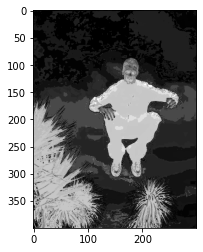

In [32]:
#Salinecy for each pixel and Display without smoothing code

S2 = [ [ 0 for i in range(len(I[0])) ] for j in range(len(I)) ]
for i in range(0,len(I)):
    for j in range(0,len(I[0])):
        r=max((1,math.ceil(R[i][j]/22)))
        g=max((1,math.ceil(G[i][j]/22)))
        b=max((1,math.ceil(B[i][j]/22)))
        hi=144*(r-1)+12*(g-1)+b
        if(hi in S):
            S2[i][j]=S[hi]
        else:
            S2[i][j]=S[mapping[hi]]
    
plt.imshow(S2,cmap='gray') 

In [33]:
# Smoothing saliency for each color
                
m=int(85/4)
S1={}
for key,value in H_85.items():
    temp_=temp[key]
    temp_={k: v for k, v in sorted(temp_.items(), key=lambda item: item[1])} #sorting to get the neares neighbours, item[1][1] for sorting second element basis
#     if(len(temp_)>m):
    temp_= dict(list(temp_.items())[0: m]) 
    T=0
    for key_,value_ in temp_.items():
        T+=value_
    for key_,value_ in temp_.items():
        if(key in S1):
            S1[key]+=((T-value_)*S[key_])
        else:
            S1[key]=((T-value_)*S[key_])
    S1[key]/=((m-1)*T)

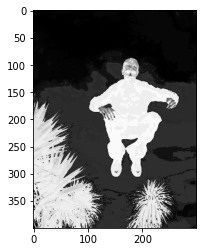

In [34]:
#Salinecy for each pixel and Display with smoothing code
S2 = [ [ 0 for i in range(len(I[0])) ] for j in range(len(I)) ]
temp={} # for storing m neighbours
for i in range(0,len(I)):
    for j in range(0,len(I[0])):
        r=max((1,math.ceil(R[i][j]/22)))
        g=max((1,math.ceil(G[i][j]/22)))
        b=max((1,math.ceil(B[i][j]/22)))
        hi=144*(r-1)+12*(g-1)+b
        if(hi in S1):
            S2[i][j]=S1[hi]
        else:
            S2[i][j]=S1[mapping[hi]]
    
plt.imshow(S2,cmap='gray') 

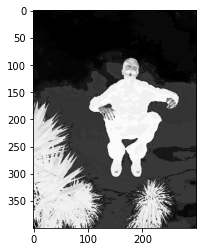

In [35]:
#Brightening of image Method

from  itertools import chain
c=100
T=list(chain.from_iterable(S2))
T=[c*math.log(i+1) for i in T]
T=np.reshape(T, (len(I), len(I[0])))
plt.imshow(T,cmap='gray') 
plt.imshow(T,cmap='gray') 
plt.show() 